# Dog Breed Classification

## Introduction

[ImageNet](https://www.image-net.org/) is one of the most popular datasets in computer vision, used mainly for image classification and localisation. Due to its vast size, subsets of this dataset can also be constructed to focus on specific problems. One such dataset is the [Stanford Dogs Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset/data), containing images of several breeds of dogs, designed for fine-grained image categorisation.

In this assignment, you will be constructing and training neural network-based models to identify the breed of the dog shown in an image. Therefore, the models that will be considered fall under the category of object recognition. Hence, many concepts in related fields (e.g. face recognition) are also applicable here.

**Acknowledgements**

The original data source can be found at http://vision.stanford.edu/aditya86/ImageNetDogs/.

*⚠️ NOTE: The link does not use https to establish a secure connection and thus you may get a security warning if you attempt to access it. Instructions on how to use the dataset will be given below.*

**Reference:**

  Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.

**ImageNet Reference:**

  J. Deng, W. Dong, R. Socher, L.-J. Li, K. Li and L. Fei-Fei, ImageNet: A Large-Scale Hierarchical Image Database. IEEE Computer Vision and Pattern Recognition (CVPR), 2009.

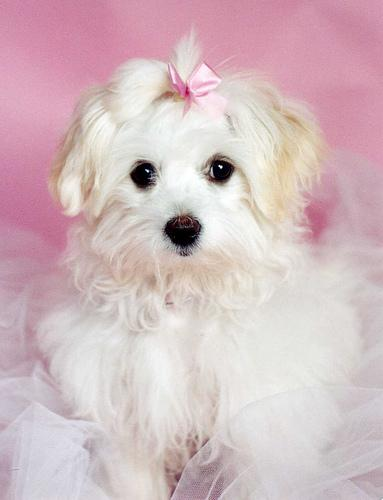

## Instructions
- The dataset is available by accessing the MECC storage (via Networks labs PCs), at `/opt/nfs/shared/images/ImageNetDogs`. The files and folders of interest are as follows:
 - **Images**: Image files
 - **Annotation**: Annotation files, containing metadata such as bounding boxes around the dog in the image
 - **README.txt**: Some information on the dataset

 *⚠️ NOTE: For this assignment, you DO NOT need to use any other files, such as file_list.mat, test_data.mat, etc.*

- This assignment is to be attempted individually.

- All code needs to be developed in Python 3. This Jupyter notebook should be used, and uploaded to the VLE once complete.

- Computers in the Networks lab can be used to train the models required to complete this assignment. It is HIGHLY recommended to use the GPUs.

- Any textual or visual information and equations that might need to be conveyed is expected to be written using the Markdown language.

- The Jupyter notebook to be submitted should be named as follows:

  `name-surname-idnumber.ipynb`

- The list of packages that are allowed for this assignment are as follows: `matplotlib`, `os`, `numpy`, `torch`, `open-cv`, `xml`, `PIL`, `torchvision` and any other packages agreed with the lecturer.

- If you use any information or material from books, papers, websites, etc., please ensure that the appropriate citations are included.

- The deadline for this assignment is **Friday, 17th January 2025 at 15:00**.

## Package Imports

Import all of the packages required in the notebook

In [1]:
# Import os for file operations
import os

# Import numpy for numerical operations
import numpy as np

# Import random for random number generation
import random

# Import PIL and matplotlib for image operations
from PIL import Image
import matplotlib.pyplot as plt

# Import torch for GPU Data processing
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

# Import torchvision for  Data transformation
from torchvision import transforms

# Import tqdm for visualizing progress bar
from tqdm.notebook import tqdm

# Import xmltodict for parsing xml files
import xmltodict



## Device Check

In [2]:

# Check and print GPU information if available
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

print(f"Device set to: {device}")

Using GPU: NVIDIA GeForce RTX 3060
Device set to: cuda


## The Data

### **Q1: Dataset Exploration** ###

Explore the dataset, to determine the characteristics of the data that you're using. Write down any observations.

*ℹ️ NOTE: Feel free to display a few examples, to get an idea of the image characteristics. Observing and understanding the characteristics of a dataset should help you design an effective way to split your data and any precautions or considerations requred when constructing your models (e.g. identifying any issues that may arise, allowing you to take preventative action). Things you could check out include the image quality, resolution, total number of images, number of classes, distribution of the number of images per class, etc.*

**(5 marks)**

Dataset directory structure:
/opt/nfs/shared/images/ImageNetDogs
├── Annotation
├── file_list.mat
├── Images
├── README.txt
├── test_data.mat
├── test_list.mat
├── train_data.mat
└── train_list.mat

2 directories, 6 files

Images folder structure:
/opt/nfs/shared/images/ImageNetDogs/Images/n02085620-Chihuahua:                      directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02085782-Japanese_spaniel:               directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02085936-Maltese_dog:                    directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02086079-Pekinese:                       directory
/opt/nfs/shared/images/ImageNetDogs/Images/n02086240-Shih-Tzu:                       directory

Number of Categories:
120

Total number of images:
20580
4 random images:


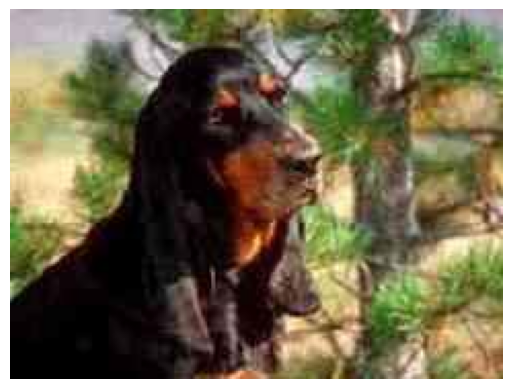


Image 1 resolution:
/opt/nfs/shared/images/ImageNetDogs/Images/n02089078-black-and-tan_coonhound/n02089078_3419.jpg : (240, 180) pixels


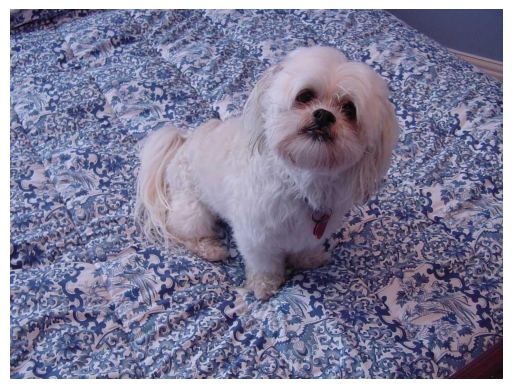


Image 2 resolution:
/opt/nfs/shared/images/ImageNetDogs/Images/n02098413-Lhasa/n02098413_7910.jpg : (1024, 768) pixels


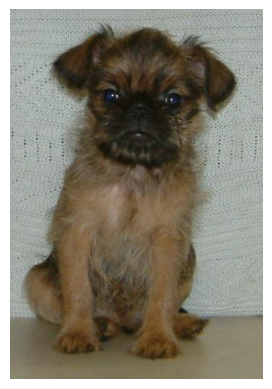


Image 3 resolution:
/opt/nfs/shared/images/ImageNetDogs/Images/n02112706-Brabancon_griffon/n02112706_2169.jpg : (328, 480) pixels


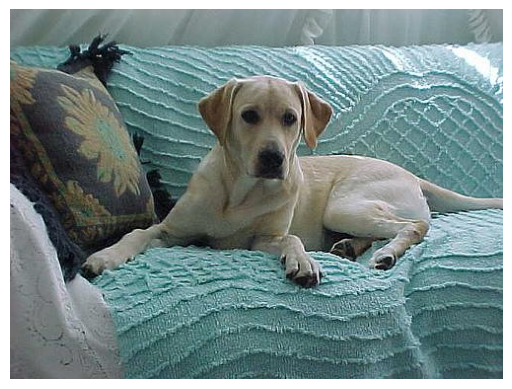


Image 4 resolution:
/opt/nfs/shared/images/ImageNetDogs/Images/n02099712-Labrador_retriever/n02099712_3301.jpg : (500, 375) pixels


In [3]:
# Define dataset directory
dataset_dir = '/opt/nfs/shared/images/ImageNetDogs'

# List dataset contents
print("Dataset directory structure:")
os.system(f'tree {dataset_dir} -L 1')

# Read the README file
#print("\nREADME file:")
#os.system(f'cat {dataset_dir}/README.txt')

# Check the structure of the Images Folder
print("\nImages folder structure:")
os.system(f'file {dataset_dir}/Images/* | head -n 5')

# Number of Categories
print("\nNumber of Categories:")
os.system(f'ls {dataset_dir}/Images | wc -l')

# Number of total images in Images folder
print("\nTotal number of images:")
os.system(f'find {dataset_dir}/Images -type f | wc -l')

# Declare the number of random images to display
ran_img = 4
# Load, display and analyze 4 random images
print(str(ran_img) + " random images:")
for i in range(ran_img):
    img_path = os.popen(f'find {dataset_dir}/Images -type f | shuf -n 1').read().strip()
    img = Image.open(img_path)
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    
    # Check the image resolution
    print("\nImage " + str(i+1) + " resolution:")
    print(f"{img_path} : {img.size} pixels")

# Check for any corrupted images
#print("\nCorrupted images:")
#os.system(f'find {directory}/Images -type f -exec identify -verbose {{}} \; | grep "Corrupt"')


# Check for duplicate images
#print("\nDuplicate images:")
#os.system(f'find {directory}/Images -type f -exec md5sum {{}} \; | sort | uniq -w 32 -dD')

**A1**:

***Directory Structure and README Analysis:***
- We first decided to check the directory structure to identify how the contents of the dataset are being stored.
- We then checked the README file to see if there was any additional information about the dataset.
- However, the README simply led us to the dataset link from Stanford.

***Dataset Overview:***
- In the Stanford link, we identified the number of categories (120 dog breeds), the average number of images per class (150), and the total number of images in the dataset (20,580).
- A quick scroll through the provided number of images per class showed that there were no outlier classes with significantly fewer images that would need to be addressed.
- These findings are confirmed in the code above.
- The Stanford link also gives a mean accuracy result based on the amount of training images per class.
- Naturally, the greater the amount of classes, the better the accuracy as it is able to distingues between more features, this at diminishing returns.
- However, this plot still has around 45 degree gradient on the higher end of images per class, suggesting the database size importance.


***Image Format and Quality Analysis:***
- Analyzing the resolution of 4 random images from the dataset.
- It was noted that all images are in JPEG format and had varied resolutions. So a method to bring them to a common resolution will need to be identified.
- A common quality index of 75 was identified on the personal system using ImageMagick.

***Corrupt and Duplicate Images:***
- There are no corrupt images.
- There are duplicate images, either in the same class, which wouldn't have any impact on the model.
- There are also duplicate images across different classes, which could be due to crossbreeds.

### **Q2: Splitting the dataset** ###
Implement code to split the dataset in such a way as to enable training and testing of a machine learning model.

**(5 marks)**

In [4]:

def split_dataset(data_dir, train_ratio=0.7, val_ratio=0.15, num_classes=None, seed=None):
    """
    Splitting the dataset into train, validation, and test sets containing a list of images, taken from different classes.

    Parameters:
    - data_dir (str): Directory path of the Images
    - train_ratio (float): Ratio of the training set split. Default is 0.7.
    - val_ratio (float): Ratio of the validation set split. Default is 0.15.
    - num_classes (int): Number of classes to use in the dataset. Default is None indicating all classes.
    - seed (int): Seed used in the random shuffling of the images. Default is None indicating no seed.

    Returns:
    - train_set (list): Training set list of images.
    - val_set (list): Validation set list of images.
    - test_set (list): Test set list of images.
    """

    # Set seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)

    # Get the sorted list of classifications
    classes = sorted(os.listdir(data_dir))
    # Check if a specified number of classes is provided
    if num_classes is not None:
        # Make an upper bound to the number of classes
        classes = classes[:num_classes]

    # Initialize the lists to store the train, validation, and test images 
    train_set = []
    val_set = []
    test_set = []

    # Iterate over the classes and split the images into the sets
    for breed in classes:
        # Get the path to the class directory
        breed_dir = os.path.join(data_dir, breed)
        # Get the list of images in the class directory
        images = [img for img in os.listdir(breed_dir) if img.endswith(('jpg', 'jpeg', 'png'))]

        # Shuffle the images
        random.shuffle(images)

        # Split the images into training, validation, and test sets
        train_split_idx = int(train_ratio * len(images))
        val_split_idx = int((train_ratio + val_ratio) * len(images))
        train_images = images[:train_split_idx]
        val_images = images[train_split_idx:val_split_idx]
        test_images = images[val_split_idx:]

        # Append the images to the train, validation, and test sets with full paths
        train_set += [os.path.join(breed_dir, img) for img in train_images]
        val_set += [os.path.join(breed_dir, img) for img in val_images]
        test_set += [os.path.join(breed_dir, img) for img in test_images]

    # Return the training, validation, and test sets
    return train_set, val_set, test_set

The split_dataset function takes the image directory path, itereates over the classes and splits the images inside each class into training and testing sets appending the full paths into a single list. The function returns the training and testing sets as lists of images. This function can be use to randomly split the dataset. However, has been constructed in a way to facilitate the reproducibility through the train_ratio, num_classes and seed parameters.

### **Q3: Custom dataset in PyTorch** ###

A lot of effort in solving any machine learning and computer vision problem goes into preparing the data. PyTorch provides a simple mechanism to define a custom dataset using `torch.utils.data.Dataset`, which is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__init__` so that it initialises the dataset
- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that `dataset[i]` can be used to get $i$-th sample.


Write a class `DataLoaderClassification` that can be used to
- Load the list of image filenames and the corresponding lables in two lists in `__init__`
- Load a batch of images and corresponding lables when one calls `__getitem__`
- Returns the length of the dataset using `__len__`

*ℹ️ NOTE: It is recommended to make use of the bounding boxes...*

**(5 marks)**

In [5]:
class DataLoaderClassification(Dataset):
    def __init__(self, image_set, breed_dict, transform=None):
        """
        Initialize the PyTorch dataset by loading the list of images and their corresponding bounding boxes and labels. We also save the transformation to apply to the images.

        Parameters:
        - image_set (list): The test, validation, or training set list of images.
        - breed_to_label (dict): A dictionary mapping the breed names to their respective labels.
        - transform (object): The transformation to be applied to the images to make them uniform.

        Returns:
        - None
        """
        self.image_set = image_set
        self.transform = transform
        self.breed_dict = breed_dict

    def __len__(self):
        return len(self.image_set)

    
    def __getitem__(self, idx):
        img_path = self.image_set[idx]
        
        # Make sure the image file exists
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image file not found: {img_path}")
    
        # Open the image
        img = Image.open(img_path)
        
        # Get the respective bounding box file path
        bbox_path = img_path.replace('Images', 'Annotation').removesuffix('.jpg') 
        
        # Check if the bounding box file exists
        if not os.path.exists(bbox_path):
            raise FileNotFoundError(f"Bounding box file not found: {bbox_path}")
        
        # Parse the bounding box XML file
        with open(bbox_path) as fd:
            doc = xmltodict.parse(fd.read())
        
        # Handle multiple objects in the annotation
        objects = doc['annotation']['object']
        if isinstance(objects, list):
            bndbox = objects[0]['bndbox']  # Use the first object's bounding box
        else:
            bndbox = objects['bndbox']
        
        xmin = int(bndbox['xmin'])
        ymin = int(bndbox['ymin'])
        xmax = int(bndbox['xmax'])
        ymax = int(bndbox['ymax'])
            
        # Crop the image using the bounding box coordinates
        img = img.crop((xmin, ymin, xmax, ymax))
        
        # Apply transformation if any
        if self.transform:
            img = self.transform(img)
        
        # Get the label from the image path using the breed_to_label dictionary
        label = self.breed_dict[img_path.split('/')[-2]]
        
        return img, label

The DataLoaderClassification class is our custom PyTorch dataset. We reinitialize the __init__, __len__ and __getitem__ methods to our implementation. 

The __init__ method takes the image_set and transform parameters. From which an object of the self object class is created. Here we have stored the passed parameters as well as the computing of the respective bounding box files and the labels.

Due to the list format of the image_set, we can easily get the length of the dataset by using the __len__ method. Furthermore, the indexing needed to be done in the __getitem__ method, is easily facilitated by the list format of the image_set. The __getitem__ method performs the self transformation on the image before returning. This enusres all images are in the same format and size before being fed into the model.

### **Q4: PyTorch dataloaders** ###

Write code that creates the PyTorch dataloaders to train and test the model.

**(5 marks)**

In [6]:
def breed_to_label(dir):
    """
    Create a dictionary mapping the breed names to labels.

    Parameters:
    - dir (str): The directory path containing the Images folder.

    Returns:
    - breed_dict(dict): A dictionary mapping the breed names to labels.
    """
    # Get the sorted list of classifications
    classes = sorted(os.listdir(dir))
    # Create a dictionary mapping the breed names to labels
    breed_dict = {breed: i for i, breed in enumerate(classes)}
    return breed_dict

In [7]:
# Define the tensor transformation to be applied to the images
transform = transforms.Compose([
    # Transform the images to a uniform size
    transforms.Resize((128, 128)),
    # Convert the images to tensors
    transforms.ToTensor(),
    # Normalize the images 
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Note we resize before converting to tensor, since in PIL format it is easier to resize and less computationally expensive

# Define the dataset image directory
directory = '/opt/nfs/shared/images/ImageNetDogs/Images'

breed_dict = breed_to_label(directory)

# Split the dataset using the split_dataset function
train_set, val_set, test_set = split_dataset(directory, train_ratio=0.7, val_ratio=0.15, num_classes=10, seed=42)

# Initialize the two datasets 
train_dataset = DataLoaderClassification(train_set, breed_dict, transform=transform)
val_dataset = DataLoaderClassification(val_set, breed_dict, transform=transform)

# Initialize the two data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

Data Loaders are used to load the data in batches. After spliting the sets and initializing the datasets, we can use the DataLoader class from PyTorch to load the data in batches. The DataLoader class takes the dataset and the batch size as parameters. The shuffle parameter is set to True for the training set and False for the testing set. This is because we want to shuffle the training set to avoid the model learning the order of the images. However, we do not want to shuffle the testing set to evaluate the model on the same images each time.

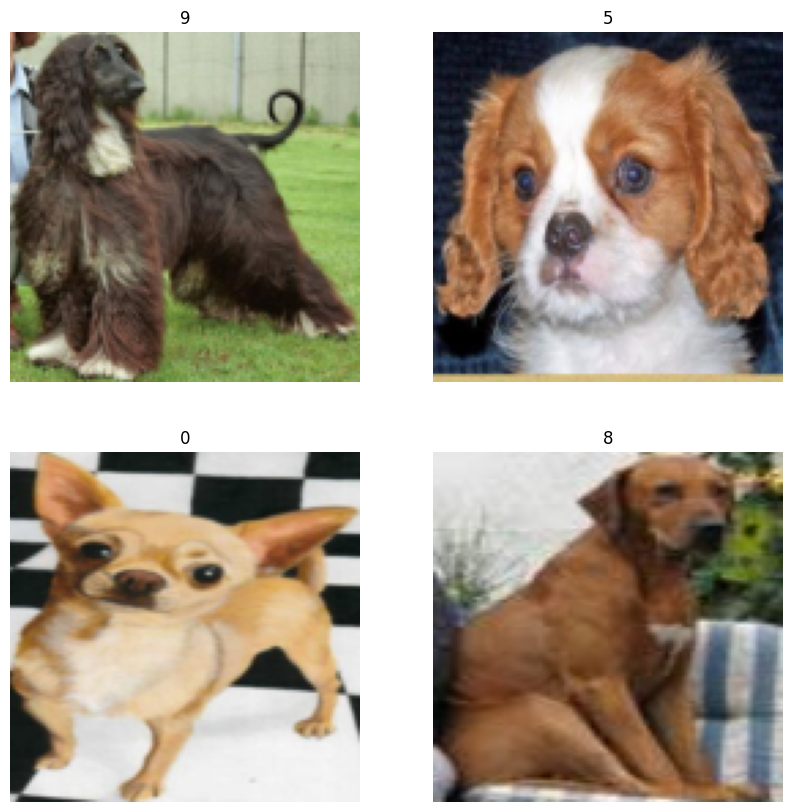

In [8]:
# Reseed the random
random.seed()
# Get 4 random image idx to check from the train loader
random_idxs = random.sample(range(len(train_dataset)), 4)

# Visualize some of the tensor transformed images
fig = plt.figure(figsize=(10, 10))
for i in range(4):
    img, label = train_dataset[random_idxs[i]]
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(label)
    ax.axis('off')

## Simple CNN

### **Q5: Define a simple CNN** ###

PyTorch provides the elegantly designed modules and classes, including `torch.nn`, to help you create and train neural networks. An `nn.Module` contains layers, and a method `forward(input)` that returns the output.

Write the `CNN` class to define a Convolutional Neural Network (CNN) where:
- The first convolutional layer (`conv1`) takes 3 input channels, outputs 16 output channels and has a kernel size of 5, a stride of 1, and padding of 2 pixels. The output of `conv1` is fed into a ReLU activation followed by a Max-pooling operator with a kernel size of 2.
- The second convolutional layer in this network (`conv2`) should have 32 filters with a kernel size of 5, a stride of 1, and padding of 2 pixels. This should be followed by a ReLU activation and a max-pooling operator with a kernel size of 2.
- The last layer is a fully-connected layer (`fc1`), which will finally output the dog breed that needs to be predicted.

In this code you should define the `__init__` and `forward` member functions.

Lastly, print the number of parameters in the model (using `torchsummary.summary`)

More information about `torch.nn` can be found [here](https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html).

**(10 marks)**

In [9]:
import torch
import torch.nn as nn
from torchsummary import summary

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 32 * 32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Get the number of classes
num_classes = len(breed_dict)

# Initialize the CNN
model = CNN(num_classes)

# Move the model to the device
model = model.to(device)

# Print the number of parameters in the model
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]           1,216
              ReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]          12,832
              ReLU-5           [-1, 32, 64, 64]               0
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Linear-7                  [-1, 120]       3,932,280
Total params: 3,946,328
Trainable params: 3,946,328
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 6.75
Params size (MB): 15.05
Estimated Total Size (MB): 21.99
----------------------------------------------------------------


The SimpleCNN class is a simple Convolutional Neural Network (CNN) model. The model is created from the PyTorch nn.Module class. The __init__ and forward methods are defined. The __init__ method initializes the layers of the model. Including the sets of convolutional and fully connected layers. The forward method defines the forward pass of the model, which is the sequence of operations that the input data goes through to produce the output. The forward method applies the convolutional and pooling layers to the input data, reshapes the output and applies the fully connected layers to produce the final output.

So the model takes the input, applies mathematical operations to it and produces the output. The model is then initialized and the summary of the model is printed. The summary shows the layers of the model, the output shape of each layer and the number of parameters in each layer. This is useful for debugging and understanding the model architecture. If the model is too complex, the summary can be used to identify the layers that need to be modified.

### **Q6: Train and evaluate the simple CNN** ###

1.   Write the code to train and evaluate the CNN specified in **Q5**. Use an Adam optimizer with the learning rate set to 0.001.
2.   Plot the accuracy against the number of epochs and write the highest accuracy achieved after 25 epochs.
3.   Save the best performing model in the folder `./Model/Simple-CNN/model.pth`.
4.   Write a function that takes as input (1) a model and (2) an image of a dog, and which outputs the dog's breed using the model.

*ℹ️ NOTE: Apart from the accuracy, feel free to check out any other metrics that may be of relevance. Apart from the overall performance, consider also checking out the performance across classes.*

*ℹ️ NOTE: The model should take less than 1 hour to train.*

**(15 marks)**

Training Progress:   0%|          | 0/25 [00:00<?, ?it/s]

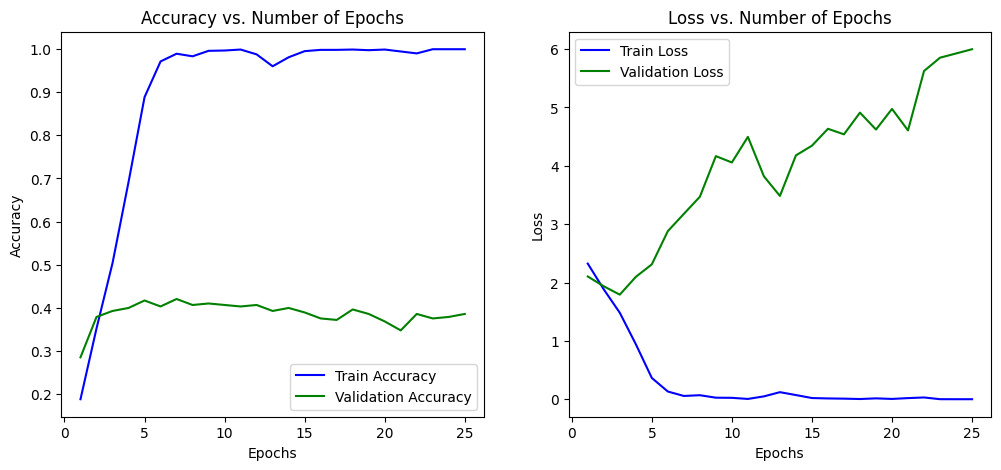

Highest Validation Accuracy: 42.01%


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

# Define the loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam, learning rate 0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 25

# Initialize lists to store the accuracies and losses at each epoch
train_accuracy_list = []
val_accuracy_list = []
train_loss_list = []
val_loss_list = []

# Initialize the best accuracy
best_accuracy = 0.0

# Initialize the progress bar for better visualization
progress_bar = tqdm(range(num_epochs), desc="Training Progress", dynamic_ncols=True)

# Training loop with progress bar
for epoch in progress_bar:
    ## Training ##
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    train_loss_list.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracy_list.append(train_accuracy)

    ## Evaluation ##
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_loss_list.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracy_list.append(val_accuracy)

    # Save the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        os.makedirs('./Model/Simple-CNN', exist_ok=True)
        torch.save(model.state_dict(), './Model/Simple-CNN/model.pth')

    # Update the progress bar with metrics
    progress_bar.set_postfix_str(
        f"Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%"
    )

# Plot the accuracy against the number of epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracy_list, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Epochs')
plt.legend()

# Plot the loss against the number of epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Number of Epochs')
plt.legend()

plt.show()

# Print the highest accuracy achieved
print(f"Highest Validation Accuracy: {100 * best_accuracy:.2f}%")

The best accuracy of the proposed network after 25 epochs is **?%**



Write a function that takes as input (1) a model and (2) an image of a dog, and which outputs the dog's breed using the model.

Try it out using an image in your testing set.

In [11]:

# Prediction function for dog breed
def predict(model, image, breed_dict):
    """
    Given a trained model and a path to a dog image, predict the breed.
    
    Args:
        model (nn.Module): The trained CNN model.
        image_path (str): Path to the image file.
        breed_dict (dict): A dictionary mapping the breed names to labels.
    Returns:
        str: Predicted breed label.
    """

    # Load the image
    img = Image.open(image).convert('RGB')
    # Apply the transformation
    img = transform(img).unsqueeze(0)

    # Move the image to the device
    img = img.to(device)
    # Set the model to evaluation mode
    model.eval()

    # Get the model prediction
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()
    
    # Map the predicted label to the breed name
    breed = list(breed_dict.keys())[list(breed_dict.values()).index(predicted_label)]

    return breed

In [12]:
# Usage :
# Get a random image path
img_path = random.choice(test_set)

# Print the image path
print(f"Image Path: {img_path}")

# Predict the breed
predicted_breed = predict(model, img_path, breed_dict)
print(f"Predicted Breed: {predicted_breed}")

Image Path: /opt/nfs/shared/images/ImageNetDogs/Images/n02086240-Shih-Tzu/n02086240_11539.jpg
Predicted Breed: n02086240-Shih-Tzu


### **Q7: Improve the simple CNN's performance** ###

Provide an overview of the model's characteristics (e.g. hyperparameters) that can be modified to try and improve performance. Then, try to improve the performance, by varying some characteristics, and train *at least* 1 additional model.

Explain the reasoning behind the hyperparameters chosen for modification, and the reasoning behind the values that are set (e.g. if you reduce the learning rate, explain why you have done this).

Plot the accuracy against the number of epochs and write the highest accuracy achieved after 25 epochs. Show the results of any other metrics that are deemed relevant.

ℹ️ *NOTE: While it is not strictly necessary to improve performance (although desirable), it is important to discuss any increase or decrease in performance, across all evaluation metrics considered (i.e. discuss why did performance increase/decrease?)*

ℹ️ *NOTE: Do NOT change the number of epochs. Similar to the model in Q6, the models should take less than 1 hour each to train.**

**(10 marks)**

In [13]:
# Inherit the CNN class to create an improved CNN model
class ImprovedCNN(CNN):
    def __init__(self):
        super(ImprovedCNN, self).__init__()  # Call the constructor of the base class (CNN)
        
        # Modify layers or add new layers to improve performance
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Increased channels
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Increased channels
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization

        self.fc1 = nn.Linear(64 * 32 * 32, len(breed_dict))  # Adjust for the increased feature map size

        self.dropout = nn.Dropout(p=0.5)  # Add dropout layer for regularization

    def forward(self, x):
        # Use the forward pass of the base class, with modifications for added layers
        x = super().forward(x)  # Call the forward pass of the original CNN class
        
        # Apply the additional modifications: BatchNorm, ReLU, Dropout
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)

        return x

# Initialize the new improved model
improved_model = ImprovedCNN()

# Move the model to the device
improved_model.to(device)

# Print the model summary
summary(improved_model, input_size=(3, 128, 128))


TypeError: CNN.__init__() missing 1 required positional argument: 'num_classes'

## Deep CNNs

### **Q8: Understanding deep CNN architectures proposed in literature** ###

There are several deep CNN methods that achieve very high classification rates. The following is a list of papers that you should check out:

1. Alexnet  [[1]](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
2. VGG model [[2]](https://www.robots.ox.ac.uk/~vgg/publications/2015/Simonyan15/simonyan15.pdf)
3. ResNet [[3]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

Discuss what innovations each network introduced, and what contributed to increased performance.

**(10 marks)**

**A8**: Write your answer here.


### **Q9: Define, train, and evaluate a deep CNN** ###

Based on your observations in **Q8**, write the class for a deep CNN model that aims to achieve a better performance than the simple CNN model above, explaining the reasoning behind the design of your model. The number of model parameters should be less than 75M.

Train the model, and plot the accuracy against the number of epochs and write the highest accuracy achieved after 50 epochs. Show the results of any other metrics that are deemed relevant, and discuss your observations.

*ℹ️ NOTE: The model should take less than 3 hours to train.*

**(10 marks)**

: 

### **Q10: Perform Transfer Learning** ###

Use the [`vgg16_bn` *pre-trained* model](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16_bn.html#torchvision.models.vgg16_bn), using `weights='IMAGENET1K_V1'`, to perform transfer learning using the Stanford Dogs dataset.

Explain the modifications and implementations done to perform transfer learning, in the Markdown text cell below.

Based on your observations of the trained model's performance, try to improve the performance by training additional models (see the cell below for more details).

For each case:

* Plot the accuracy against the number of epochs and write the highest accuracy achieved after 50 epochs. Similar to previous questions, show the results of any other metrics that are deemed relevant.

* Discuss how you are performing the fine-tuning

* Discuss observations from model training and evaluation

*ℹ️ *NOTE: Feel free to use the function you created in Q6 to input an image and a model and output the breed of the dog depicted in the image as determined by the model.*

*ℹ️ NOTE: The model should take less than 2.5 hours to train.*

**(15 marks)**

**A10**: Write your answer here.

: 

Try to improve the performance, by varying characteristics such as the model hyperparameters, and train *at least* 2 additional models.

For each model, explain the reasoning behind (1) the *characteristics* chosen for modification, and (2) the *values* that are set (e.g. if you reduce the learning rate, explain why you have done this).

*ℹ️ NOTE: As before, the models should take less than 2.5 hours each to train.*

: 

## Conclusions & Future Work

### **Q11: Model Deployment** ###

Let's say that you are asked to deploy one of your models in practice. Which of the models that you have trained would you select, and why?

ℹ️ *NOTE: Compare your models, and discuss any advantages, limitations, and any future work that could be performed to make the chosen model more suitable for real-world deployment.*

**(10 marks)**

**A11**: Write your answer here.




**END OF ASSIGNMENT**

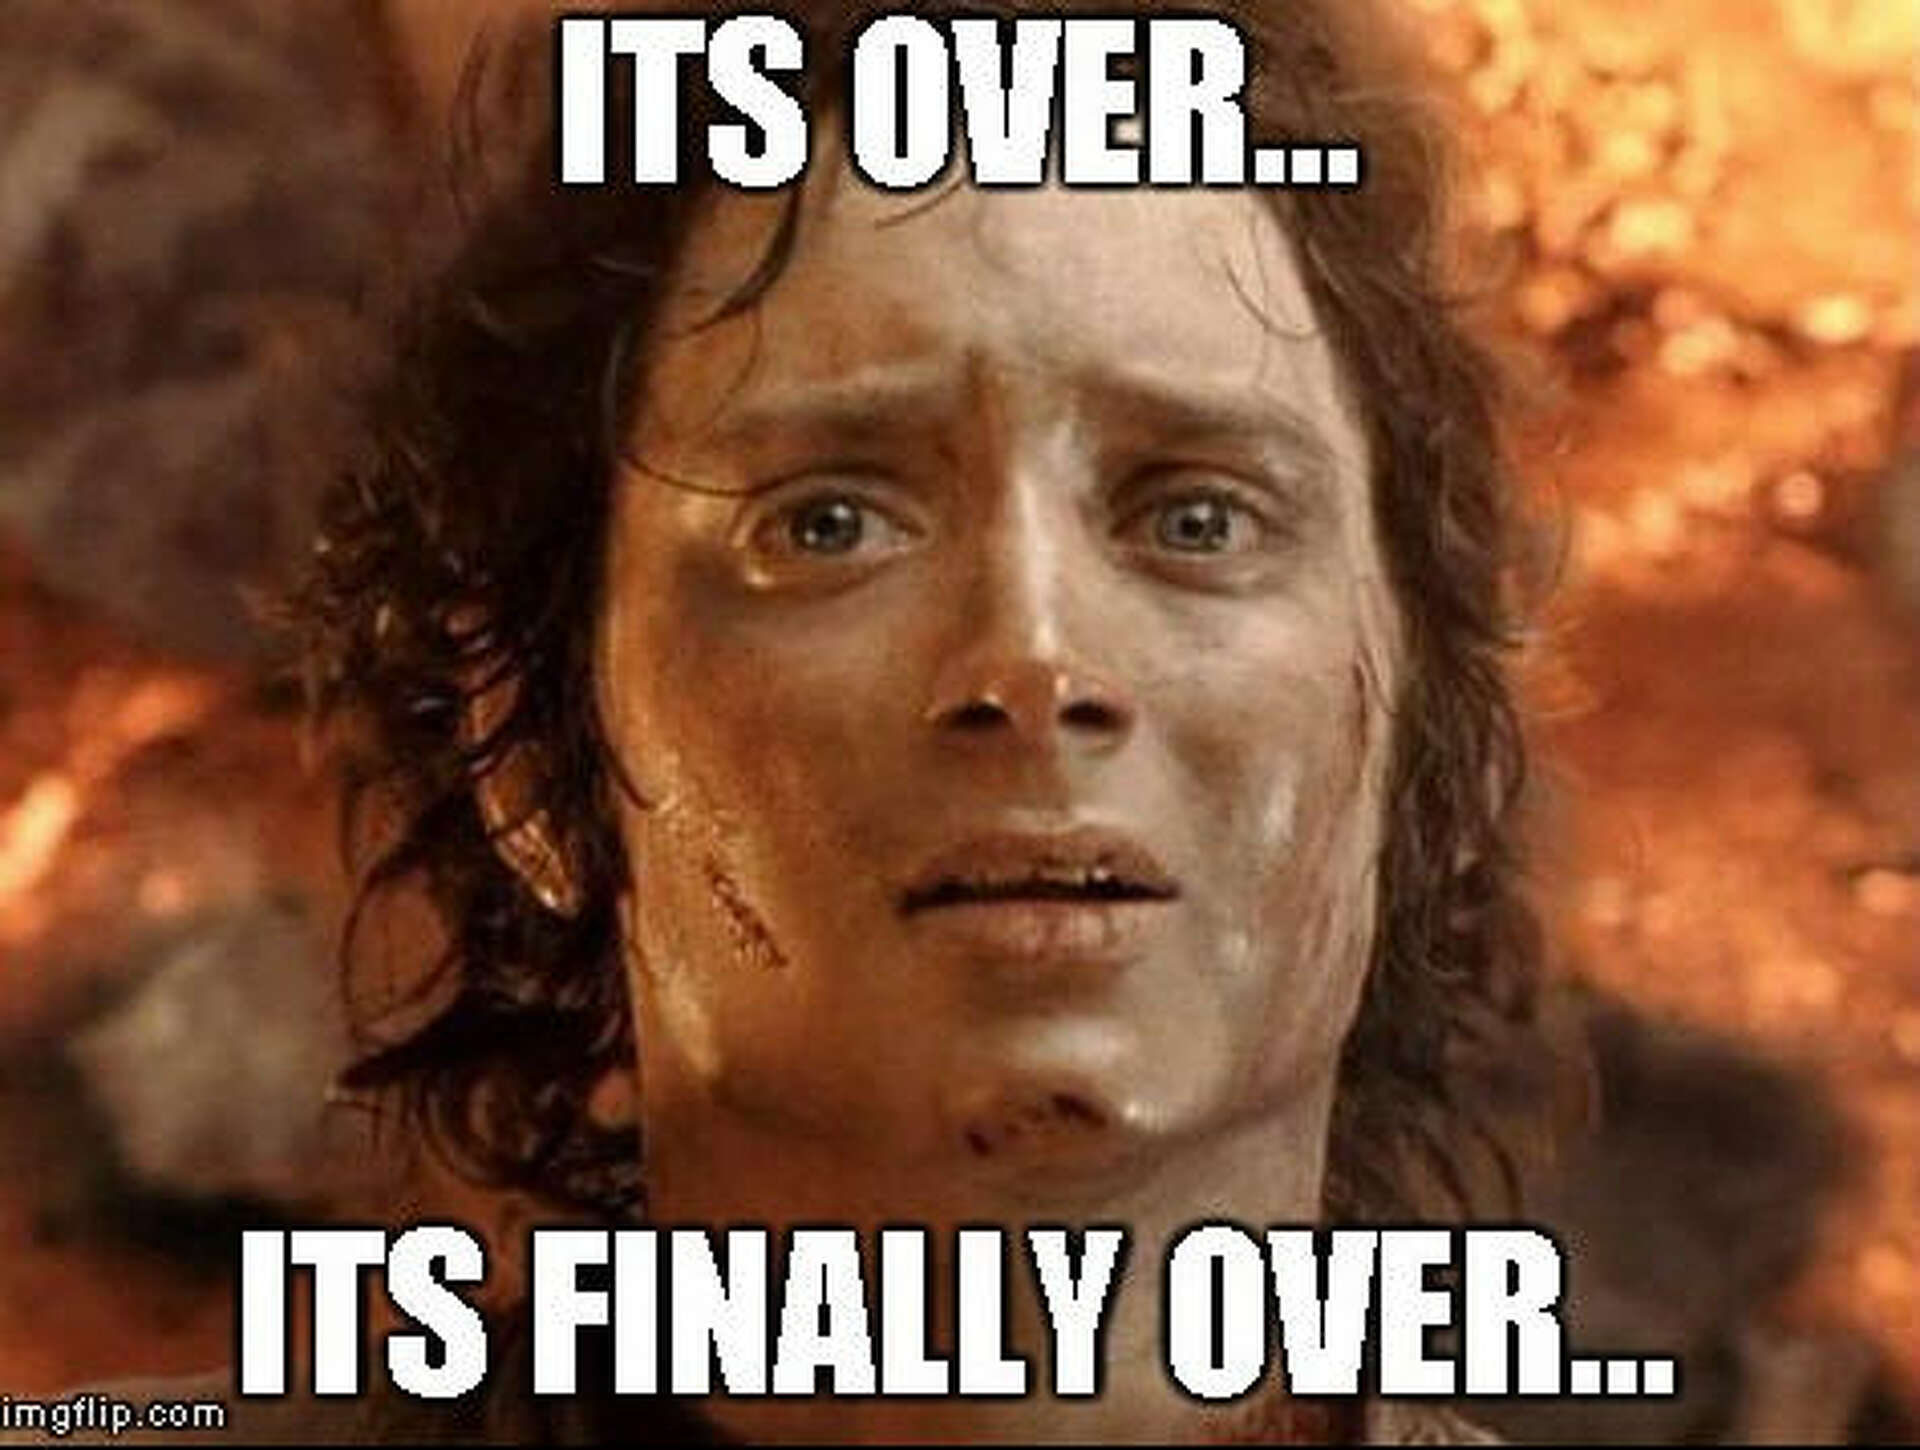